In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

# masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
        0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
        0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
        1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
        0.33863009])
# total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses)
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33
# UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
# projected separation divided by effective radius from Georgiev
#UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
      # 0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
       #1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
       #0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
       #1.22266667])
# physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e

# a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

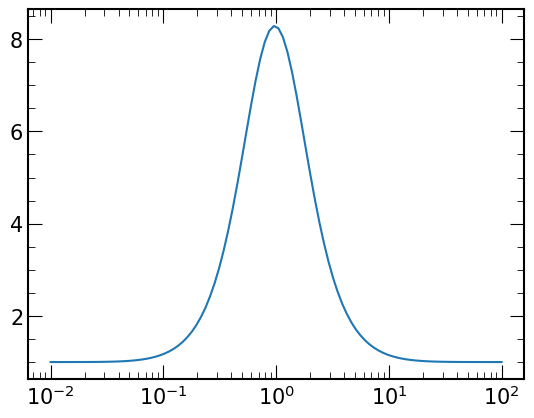

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-3-ccfc426fb624>:28: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
8.321049690246582
1.5 0.1


<ipython-input-3-ccfc426fb624>:42: RuntimeWarning: divide by zero encountered in log10
  return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
<ipython-input-3-ccfc426fb624>:42: RuntimeWarning: divide by zero encountered in log10
  return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))


finished until t = 0.0 0.8735175132751465


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 5.121410608291626
finished until t = 1.0 11.453890800476074
finished until t = 1.5 19.501604557037354
finished until t = 2.0 29.08860421180725
finished until t = 2.5 40.106316566467285
finished until t = 3.0 52.3204185962677
finished until t = 3.5 65.75254940986633
finished until t = 4.0 80.36974835395813
finished until t = 4.5 95.41841745376587
finished until t = 5.0 111.48219513893127
finished until t = 5.5 128.38024520874023
finished until t = 6.0 146.63778400421143
finished until t = 6.5 166.3115222454071
finished until t = 7.0 187.18143892288208
finished until t = 7.5 208.8212854862213
finished until t = 8.0 231.49359440803528
finished until t = 8.5 255.3256278038025
finished until t = 9.0 280.0593070983887
finished until t = 9.5 305.7151072025299
finished until t = 10.0 332.34806180000305


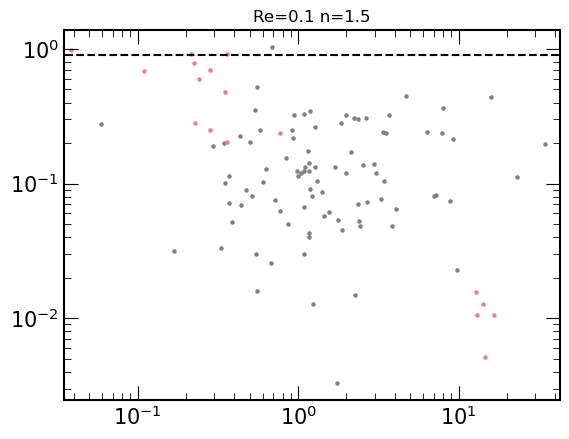

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
6.9655866622924805
1.5 0.3
finished until t = 0.0 0.412977933883667
finished until t = 0.5 3.6473422050476074
finished until t = 1.0 9.811273336410522
finished until t = 1.5 18.38017201423645
finished until t = 2.0 29.41977310180664
finished until t = 2.5 42.32109236717224
finished until t = 3.0 56.92220330238342
finished until t = 3.5 73.00336003303528
finished until t = 4.0 90.51111674308777
finished until t = 4.5 109.22581052780151
finished until t = 5.0 129.19161295890808
finished until t = 5.5 150.6850974559784
finished until t = 6.0 173.32620692253113
finished until t = 6.5 197.1325399875641
finished until t = 7.0 222.42765736579895
finished until t = 7.5 248.614563703537
finished until t = 8.0 275.79096031188965
finished until t = 8.5 304.16172456741333
finished until t = 9.0 333.58441185951233
finished until t = 9.5 364.22753047943115
finished until t = 10.0 395.6240737438202


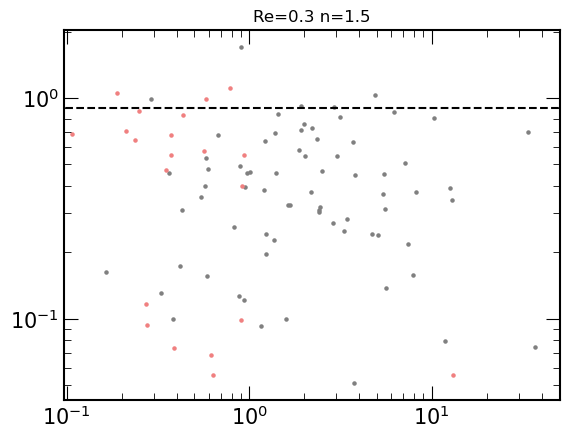

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.325667858123779
1.5 0.5
finished until t = 0.0 0.506310224533081
finished until t = 0.5 4.763706684112549
finished until t = 1.0 12.823325395584106
finished until t = 1.5 24.716691255569458
finished until t = 2.0 40.05272579193115
finished until t = 2.5 59.992926359176636
finished until t = 3.0 83.27757930755615
finished until t = 3.5 110.82601046562195
finished until t = 4.0 141.64229536056519
finished until t = 4.5 175.80179691314697
finished until t = 5.0 214.16918206214905
finished until t = 5.5 260.1960144042969
finished until t = 6.0 311.8932318687439
finished until t = 6.5 365.7599182128906
finished until t = 7.0 431.0812237262726
finished until t = 7.5 500.1469886302948
finished until t = 8.0 573.4928488731384
finished until t = 8.5 649.8361468315125
finished until t = 9.0 731.2011730670929
finished until t = 9.5 816.16193318367
finished until t = 10.0 904.2777495384216


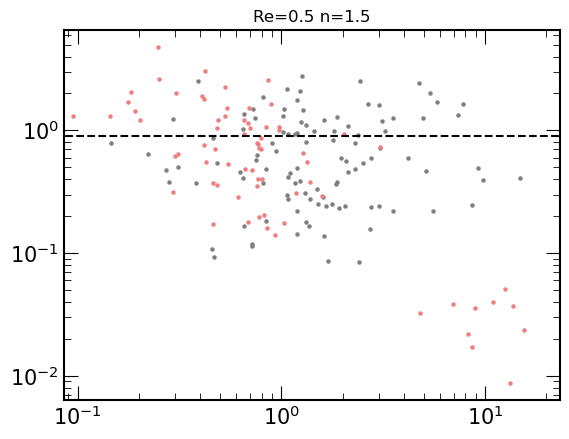

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.357211351394653
1.5 0.7
finished until t = 0.0 0.7462244033813477
finished until t = 0.5 5.446326971054077
finished until t = 1.0 14.47310757637024
finished until t = 1.5 28.0996732711792
finished until t = 2.0 45.94483041763306
finished until t = 2.5 67.70327830314636
finished until t = 3.0 93.98335075378418
finished until t = 3.5 124.68870425224304
finished until t = 4.0 160.1482982635498
finished until t = 4.5 199.99944353103638
finished until t = 5.0 244.55646872520447
finished until t = 5.5 293.0003008842468
finished until t = 6.0 346.087459564209
finished until t = 6.5 403.81729078292847
finished until t = 7.0 464.9797716140747
finished until t = 7.5 530.3450090885162
finished until t = 8.0 599.8951902389526
finished until t = 8.5 674.4842438697815
finished until t = 9.0 752.1642904281616
finished until t = 9.5 834.1065294742584
finished until t = 10.0 920.5139708518982


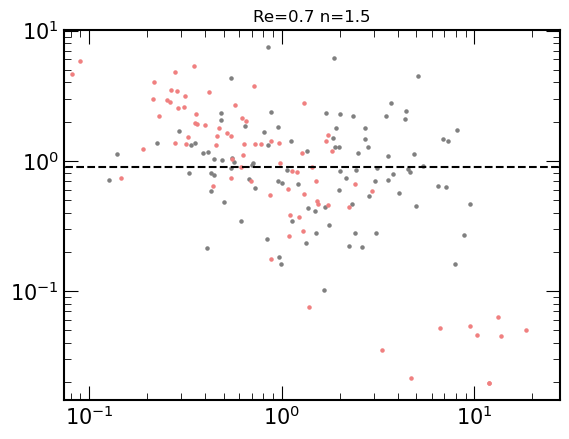

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.76683759689331
1.5 0.9
finished until t = 0.0 0.6892044544219971
finished until t = 0.5 5.180163860321045
finished until t = 1.0 13.493557691574097
finished until t = 1.5 25.977478981018066
finished until t = 2.0 42.77182221412659
finished until t = 2.5 63.183414697647095
finished until t = 3.0 89.07782864570618
finished until t = 3.5 118.00591039657593
finished until t = 4.0 151.16044354438782
finished until t = 4.5 188.60005116462708
finished until t = 5.0 230.38577127456665
finished until t = 5.5 276.1601183414459
finished until t = 6.0 326.28920245170593
finished until t = 6.5 380.42177867889404
finished until t = 7.0 438.7214996814728
finished until t = 7.5 501.43210315704346
finished until t = 8.0 568.0353856086731
finished until t = 8.5 639.9166667461395
finished until t = 9.0 716.6920998096466
finished until t = 9.5 796.3235478401184
finished until t = 10.0 880.7711062431335


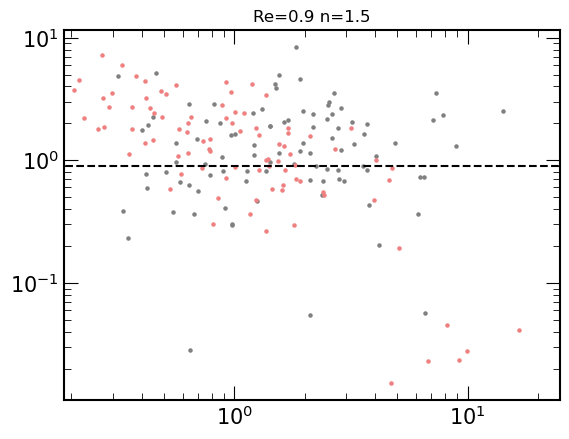

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.00452184677124
1.5 1.1
finished until t = 0.0 0.6203246116638184
finished until t = 0.5 4.644326448440552
finished until t = 1.0 12.824876308441162
finished until t = 1.5 25.05222773551941
finished until t = 2.0 40.20359516143799
finished until t = 2.5 59.13136315345764
finished until t = 3.0 82.10274744033813
finished until t = 3.5 108.14021635055542
finished until t = 4.0 138.29485774040222
finished until t = 4.5 173.44807815551758
finished until t = 5.0 213.00868129730225
finished until t = 5.5 255.16065979003906
finished until t = 6.0 301.4618306159973
finished until t = 6.5 351.90764474868774
finished until t = 7.0 406.196964263916
finished until t = 7.5 464.7033302783966
finished until t = 8.0 526.6275751590729
finished until t = 8.5 592.5528535842896
finished until t = 9.0 662.5646524429321
finished until t = 9.5 735.7593743801117
finished until t = 10.0 811.9237327575684


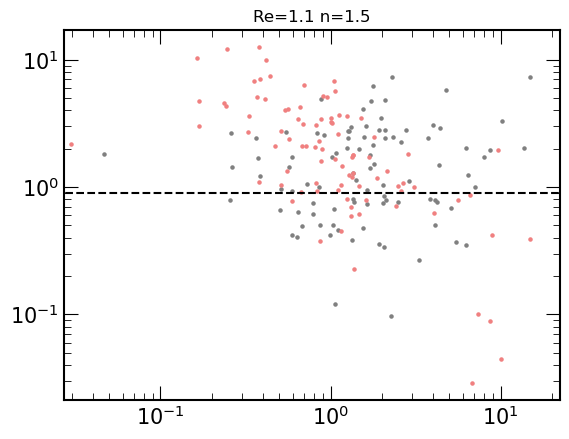

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.551942825317383
1.5 1.3
finished until t = 0.0 0.623629093170166
finished until t = 0.5 4.833597898483276
finished until t = 1.0 12.61266565322876
finished until t = 1.5 23.963900327682495
finished until t = 2.0 38.894286155700684
finished until t = 2.5 57.46655297279358
finished until t = 3.0 79.5352520942688
finished until t = 3.5 105.3653073310852
finished until t = 4.0 134.7228662967682
finished until t = 4.5 167.81442379951477
finished until t = 5.0 204.8191556930542
finished until t = 5.5 245.53919672966003
finished until t = 6.0 289.3514552116394
finished until t = 6.5 336.90400862693787
finished until t = 7.0 388.45249581336975
finished until t = 7.5 443.8148066997528
finished until t = 8.0 502.6370015144348
finished until t = 8.5 565.9179973602295
finished until t = 9.0 633.0980143547058
finished until t = 9.5 704.5190906524658
finished until t = 10.0 779.3703098297119


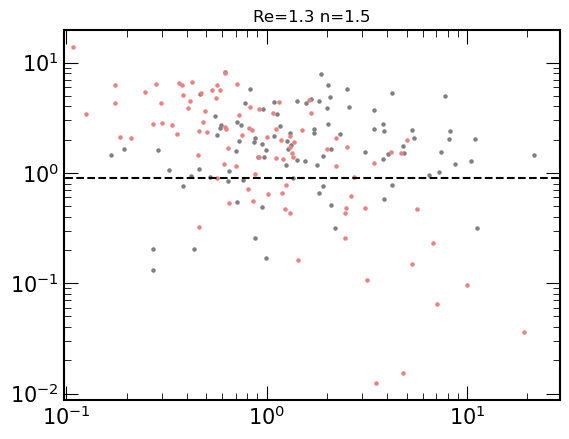

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.827058792114258
1.5 1.5
finished until t = 0.0 0.7297418117523193
finished until t = 0.5 5.620335578918457
finished until t = 1.0 13.977317333221436
finished until t = 1.5 26.08160901069641
finished until t = 2.0 42.021435499191284
finished until t = 2.5 62.304330825805664
finished until t = 3.0 85.92595839500427
finished until t = 3.5 113.89759349822998
finished until t = 4.0 145.66848278045654
finished until t = 4.5 181.27278876304626
finished until t = 5.0 222.43323159217834
finished until t = 5.5 268.83288836479187
finished until t = 6.0 317.93935537338257
finished until t = 6.5 374.93237042427063
finished until t = 7.0 433.3104815483093
finished until t = 7.5 495.29419803619385
finished until t = 8.0 563.1858024597168
finished until t = 8.5 635.0867428779602
finished until t = 9.0 709.3836009502411
finished until t = 9.5 788.0832531452179
finished until t = 10.0 871.2051017284393


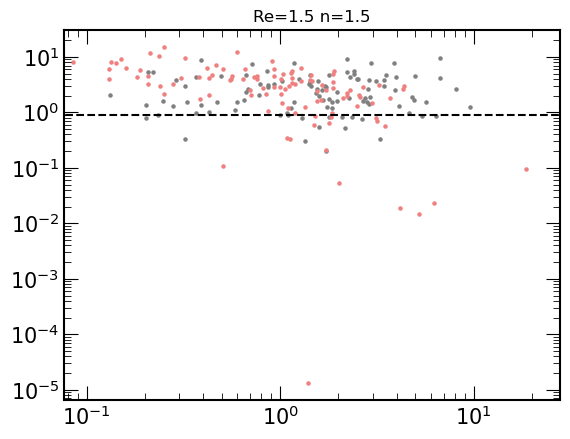

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.80193281173706
1.5 1.7
finished until t = 0.0 0.6374006271362305
finished until t = 0.5 4.633525133132935
finished until t = 1.0 12.000869750976562
finished until t = 1.5 22.85105299949646
finished until t = 2.0 37.242340326309204
finished until t = 2.5 55.00132989883423
finished until t = 3.0 76.0687050819397
finished until t = 3.5 100.52727055549622
finished until t = 4.0 128.43959617614746
finished until t = 4.5 159.7436010837555
finished until t = 5.0 194.4525501728058
finished until t = 5.5 232.6413700580597
finished until t = 6.0 274.2621924877167
finished until t = 6.5 319.342631816864
finished until t = 7.0 367.87085604667664
finished until t = 7.5 420.030047416687
finished until t = 8.0 475.7289855480194
finished until t = 8.5 534.8692314624786
finished until t = 9.0 598.0754895210266
finished until t = 9.5 666.0293347835541
finished until t = 10.0 737.3689787387848


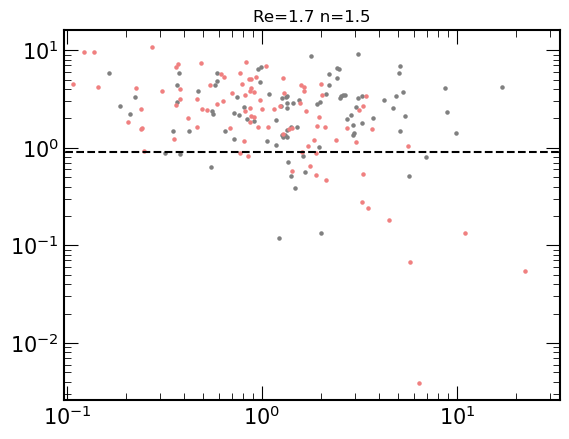

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.786497831344604
1.5 1.9
finished until t = 0.0 0.5952222347259521
finished until t = 0.5 4.1811683177948
finished until t = 1.0 10.762099742889404
finished until t = 1.5 20.376258850097656
finished until t = 2.0 33.07291769981384
finished until t = 2.5 48.77840781211853
finished until t = 3.0 67.58664441108704
finished until t = 3.5 89.58410334587097
finished until t = 4.0 114.72439289093018
finished until t = 4.5 143.16861939430237
finished until t = 5.0 174.59807014465332
finished until t = 5.5 209.02335286140442
finished until t = 6.0 246.0717270374298
finished until t = 6.5 285.57341742515564
finished until t = 7.0 329.04720854759216
finished until t = 7.5 375.5618402957916
finished until t = 8.0 424.78981924057007
finished until t = 8.5 477.44861674308777
finished until t = 9.0 533.4536135196686
finished until t = 9.5 592.6904063224792
finished until t = 10.0 655.4122998714447


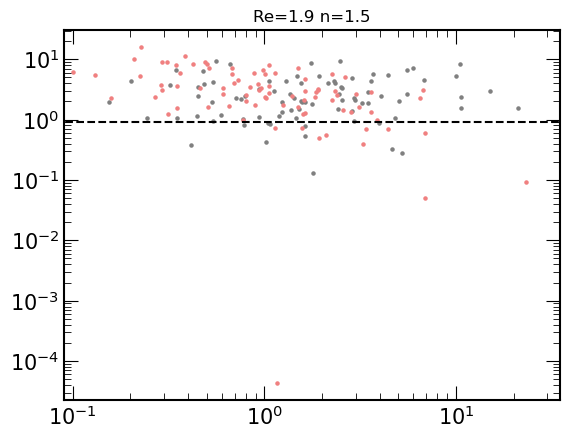

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.063385963439941
1.5 2.1
finished until t = 0.0 0.68216872215271
finished until t = 0.5 5.04731011390686
finished until t = 1.0 13.20119047164917
finished until t = 1.5 25.116951942443848
finished until t = 2.0 40.82844543457031
finished until t = 2.5 60.334012031555176
finished until t = 3.0 83.64259195327759
finished until t = 3.5 110.54257154464722
finished until t = 4.0 141.31837701797485
finished until t = 4.5 171.7144684791565
finished until t = 5.0 204.9889521598816
finished until t = 5.5 241.50993657112122
finished until t = 6.0 281.31812381744385
finished until t = 6.5 324.5941562652588
finished until t = 7.0 371.22053718566895
finished until t = 7.5 421.4387242794037
finished until t = 8.0 475.40189027786255
finished until t = 8.5 533.6315100193024
finished until t = 9.0 594.8443028926849
finished until t = 9.5 659.750230550766
finished until t = 10.0 727.9091646671295


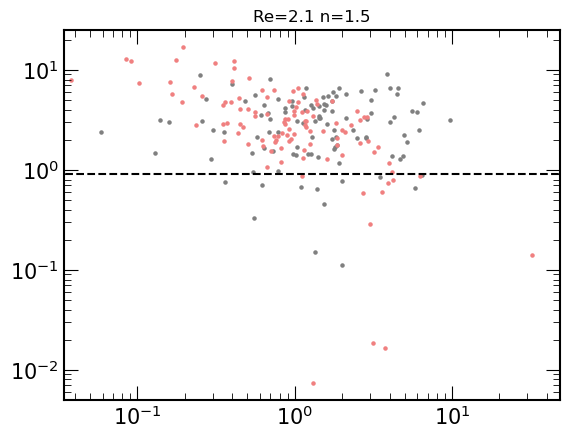

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.793277025222778
1.5 2.3
finished until t = 0.0 0.5517580509185791
finished until t = 0.5 4.112748861312866
finished until t = 1.0 10.6974196434021
finished until t = 1.5 20.329336166381836
finished until t = 2.0 33.06968641281128
finished until t = 2.5 48.88789415359497
finished until t = 3.0 67.71766519546509
finished until t = 3.5 89.87216281890869
finished until t = 4.0 114.88785886764526
finished until t = 4.5 142.96642589569092
finished until t = 5.0 174.19209361076355
finished until t = 5.5 208.47305822372437
finished until t = 6.0 245.91162419319153
finished until t = 6.5 286.56534004211426
finished until t = 7.0 330.5668046474457
finished until t = 7.5 377.8094894886017
finished until t = 8.0 428.26550006866455
finished until t = 8.5 482.11854243278503
finished until t = 9.0 539.465708732605
finished until t = 9.5 600.7217330932617
finished until t = 10.0 665.5443739891052


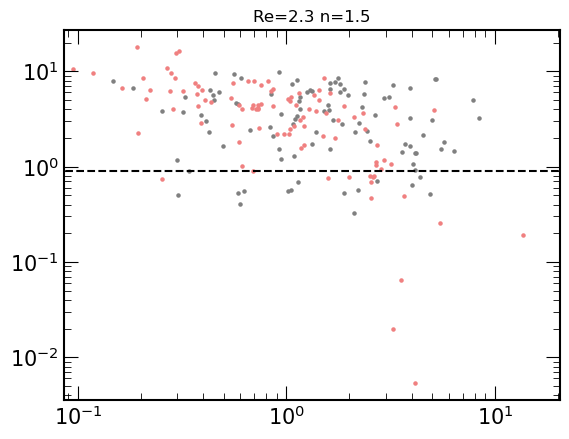

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.788814067840576
1.5 2.5
finished until t = 0.0 0.5543839931488037
finished until t = 0.5 3.806797981262207
finished until t = 1.0 9.807883024215698
finished until t = 1.5 18.547391176223755
finished until t = 2.0 29.950202226638794
finished until t = 2.5 44.06981015205383
finished until t = 3.0 60.84058856964111
finished until t = 3.5 80.28602886199951
finished until t = 4.0 102.58469486236572
finished until t = 4.5 127.49619936943054
finished until t = 5.0 155.50994086265564
finished until t = 5.5 186.50509333610535
finished until t = 6.0 219.85980653762817
finished until t = 6.5 255.76875162124634
finished until t = 7.0 294.50510334968567
finished until t = 7.5 336.3120822906494
finished until t = 8.0 380.7097864151001
finished until t = 8.5 427.6306664943695
finished until t = 9.0 477.256507396698
finished until t = 9.5 529.8387832641602
finished until t = 10.0 585.2758905887604


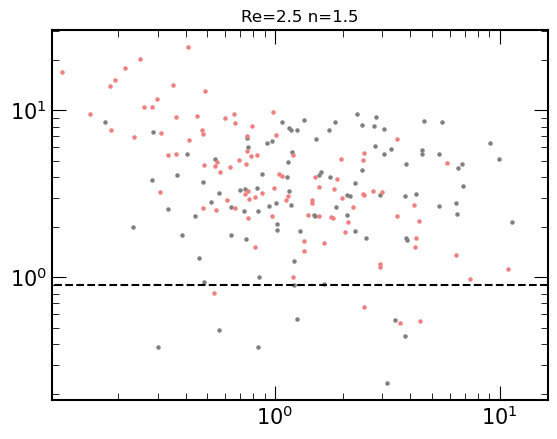

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.849450826644897
1.5 2.7
finished until t = 0.0 0.53059983253479
finished until t = 0.5 3.842587471008301
finished until t = 1.0 9.974520206451416
finished until t = 1.5 19.01424527168274
finished until t = 2.0 30.911173343658447
finished until t = 2.5 45.71504330635071
finished until t = 3.0 63.41535806655884
finished until t = 3.5 86.09640288352966
finished until t = 4.0 111.05696249008179
finished until t = 4.5 139.61189436912537
finished until t = 5.0 171.1333498954773
finished until t = 5.5 206.12522292137146
finished until t = 6.0 244.32413148880005
finished until t = 6.5 285.8530602455139
finished until t = 7.0 331.7034115791321
finished until t = 7.5 374.420117855072
finished until t = 8.0 420.59682726860046
finished until t = 8.5 469.5289387702942
finished until t = 9.0 520.9378898143768
finished until t = 9.5 576.2602417469025
finished until t = 10.0 634.3676655292511


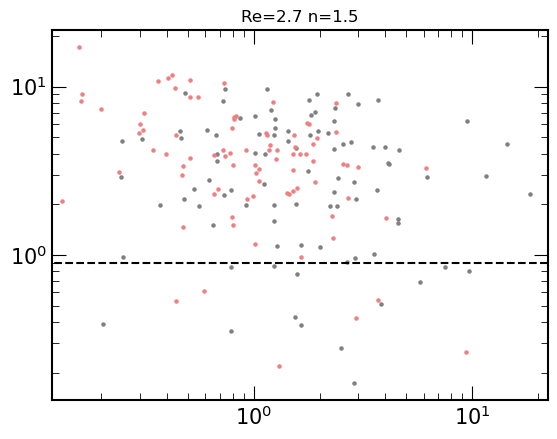

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.221128940582275
1.5 2.9
finished until t = 0.0 0.5180296897888184
finished until t = 0.5 3.539898633956909
finished until t = 1.0 9.522725105285645
finished until t = 1.5 17.84032678604126
finished until t = 2.0 28.357356309890747
finished until t = 2.5 40.3800745010376
finished until t = 3.0 54.6863899230957
finished until t = 3.5 71.61637544631958
finished until t = 4.0 90.61864972114563
finished until t = 4.5 112.42864155769348
finished until t = 5.0 135.67924308776855
finished until t = 5.5 162.1332938671112
finished until t = 6.0 190.5116674900055
finished until t = 6.5 221.1628496646881
finished until t = 7.0 254.15013933181763
finished until t = 7.5 289.6179096698761
finished until t = 8.0 326.8527009487152
finished until t = 8.5 366.4660441875458
finished until t = 9.0 408.12374997138977
finished until t = 9.5 449.69843792915344
finished until t = 10.0 494.0282428264618


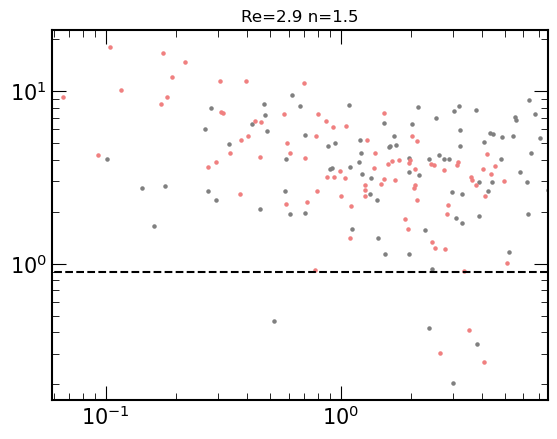

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.735837697982788
1.5 3.1
finished until t = 0.0 0.4226193428039551
finished until t = 0.5 2.912003993988037
finished until t = 1.0 7.485627889633179
finished until t = 1.5 14.306206226348877
finished until t = 2.0 22.808826208114624
finished until t = 2.5 33.77507996559143
finished until t = 3.0 46.770071029663086
finished until t = 3.5 61.62177038192749
finished until t = 4.0 78.7005603313446
finished until t = 4.5 97.68971848487854
finished until t = 5.0 118.67752194404602
finished until t = 5.5 142.35338377952576
finished until t = 6.0 167.57377004623413
finished until t = 6.5 195.15339994430542
finished until t = 7.0 225.09894919395447
finished until t = 7.5 257.2757399082184
finished until t = 8.0 291.465128660202
finished until t = 8.5 327.67475724220276
finished until t = 9.0 366.36705136299133
finished until t = 9.5 406.75256538391113
finished until t = 10.0 449.7488000392914


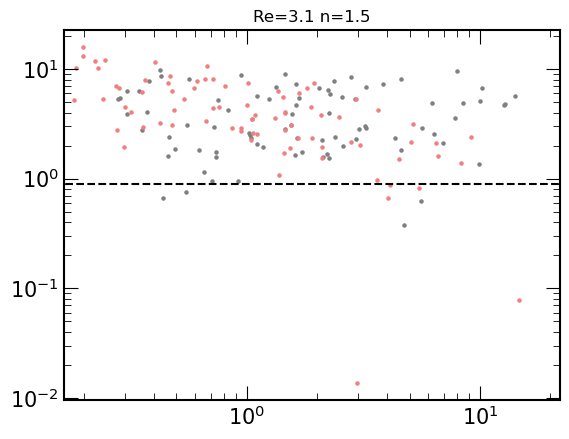

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.725054502487183
1.5 3.3
finished until t = 0.0 0.4713764190673828
finished until t = 0.5 3.1299691200256348
finished until t = 1.0 7.968846559524536
finished until t = 1.5 15.26227855682373
finished until t = 2.0 24.49192476272583
finished until t = 2.5 36.26005434989929
finished until t = 3.0 50.274983167648315
finished until t = 3.5 66.36163663864136
finished until t = 4.0 84.54429388046265
finished until t = 4.5 104.96674942970276
finished until t = 5.0 128.31008386611938
finished until t = 5.5 153.24168729782104
finished until t = 6.0 180.74044370651245
finished until t = 6.5 210.63845705986023
finished until t = 7.0 242.51862478256226
finished until t = 7.5 277.14572644233704
finished until t = 8.0 313.7028796672821
finished until t = 8.5 352.87074875831604
finished until t = 9.0 394.7761151790619
finished until t = 9.5 439.5949969291687
finished until t = 10.0 485.89175295829773


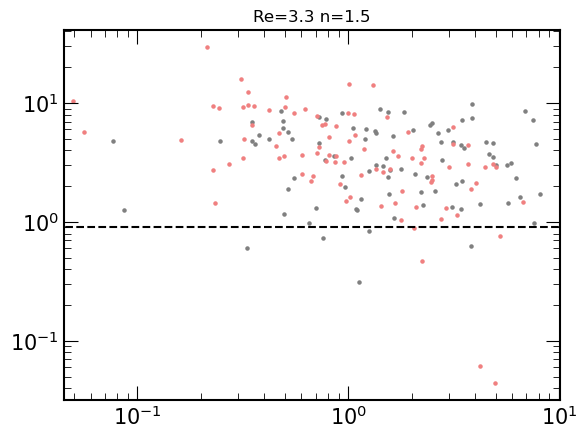

In [3]:
#NFW

n_values = [1.5]

R_e_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'ZoomNFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('ZoomNFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             